# Feature and Parameters Analyzing

Base Zone Encoded

In [322]:
train.columns

Index(['y', 'square_meters', 'contract_type', 'availability', 'description',
       'other_features', 'conditions', 'floor', 'elevator',
       'energy_efficiency_class', 'condominium_fees', 'zone',
       'availability_date', 'is_available', 'availability_encoded',
       'energy_class_num', 'energy_efficiency_class_encoded',
       'conditions_encoded', 'floor_num', 'elevator_sign', 'floor_effect',
       'total_rooms', 'num_bedrooms', 'num_other_rooms', 'num_bathrooms',
       'kitchen_open', 'kitchen_diner', 'kitchen_nook', 'kitchen_semi',
       'kitchenette', 'kitchen_none', 'suitable_disabled', 'furnished',
       'security door', 'centralized tv system', 'optic fiber',
       'window_double_glass', 'balcony', 'full day concierge',
       'video entryphone', 'window_pvc', 'closet', 'electric gate',
       'shared garden', 'window_wood', 'window_metal', 'half-day concierge',
       'cellar', 'terrace', 'partially furnished', 'alarm system', 'kitchen',
       'only kitchen furnish

[0]	train-rmse:1282.15834	eval-rmse:1244.49314
[100]	train-rmse:386.79088	eval-rmse:535.08653
[200]	train-rmse:317.28356	eval-rmse:518.35698
[300]	train-rmse:280.82869	eval-rmse:513.13855
[400]	train-rmse:252.94309	eval-rmse:510.87882
[500]	train-rmse:226.93260	eval-rmse:509.22862
[584]	train-rmse:208.45497	eval-rmse:508.78966
✅ Final Validation MAE: 307.2275
📌 Predictions stored in test['y_predicted']


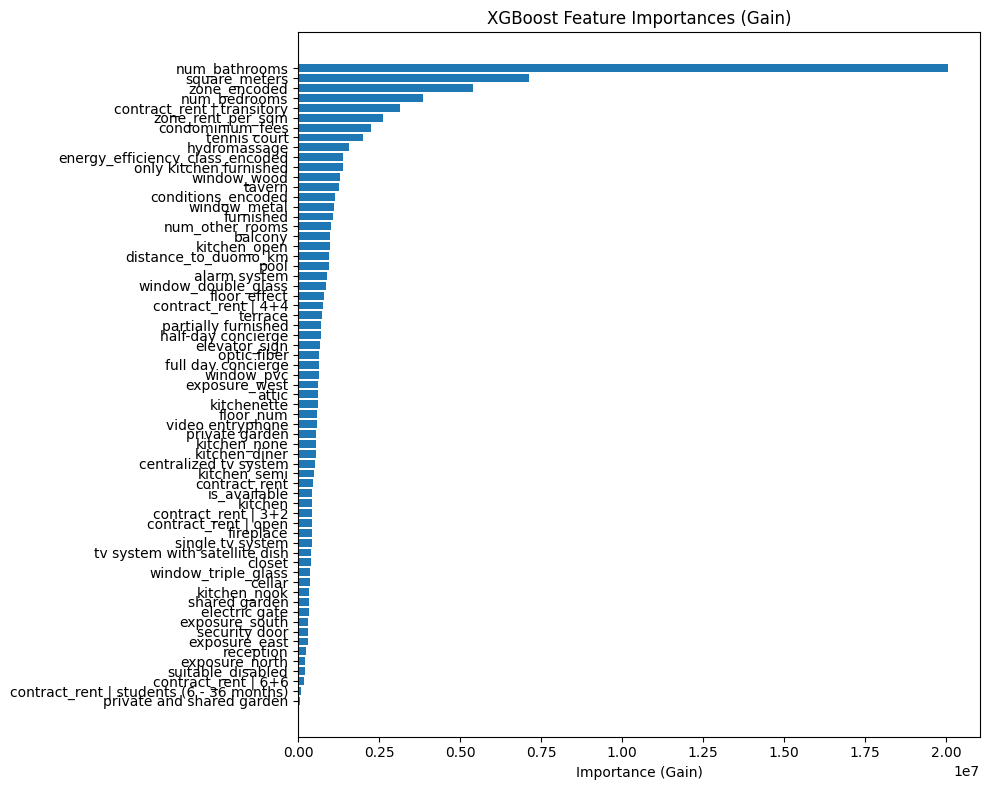

In [323]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Drop irrelevant columns
# Keep this list consistent with columns you want to exclude from modeling
excluded_columns = [
    'y', 'contract_type', 'availability_encoded','availability', 'availability_date',
    'description', 'other_features', 'energy_efficiency_class',
    'energy_class_num', 'total_rooms', 'elevator', 'floor',
    'conditions', 'zone', 'zone_grouped','y_predicted'
]

# Step 2: Prepare data
# Drop columns from the train and test sets
X = train.drop(columns=excluded_columns, errors='ignore')
X_test = test.drop(columns=excluded_columns, errors='ignore') # Apply drop to test as well

# Define the target variable
y = train['y']

# Save feature names from the training data *after* dropping
feature_names = X.columns.tolist()

# --- Column Alignment Fix ---
# Ensure X_test has the exact same columns as X (defined by feature_names)
# This step is crucial to prevent the ValueError when creating dtest
missing_cols_in_test = set(feature_names) - set(X_test.columns)
for c in missing_cols_in_test:
    # Add missing columns to X_test, filling with 0 (or another appropriate default/imputation)
    # Consider if a different fill value makes sense for your features (e.g., mean/median)
    X_test[c] = 0

extra_cols_in_test = set(X_test.columns) - set(feature_names)
if extra_cols_in_test:
    print(f"Warning: Dropping extra columns in X_test not present in X: {extra_cols_in_test}")
    # Drop columns in X_test that are not in feature_names
    X_test = X_test[feature_names]

# Ensure the order of columns in X_test is the same as in X
X_test = X_test[feature_names]
# --- End Column Alignment Fix ---


# Step 3: Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 4: Wrap in DMatrix with consistent feature names
# Use the aligned X_train and X_test, and the shared feature_names
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, feature_names=feature_names) # X_test should now match feature_names

# Step 5: Set XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'seed': 42,
    'verbosity': 1
}

# Step 6: Train the model with early stopping
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=100
)

# Step 7: Predict and evaluate
y_pred_val = model.predict(dval)
mae = mean_absolute_error(y_val, y_pred_val)
print(f"✅ Final Validation MAE: {mae:.4f}")

y_pred_test = model.predict(dtest)
# Check if 'y_predicted' column already exists before assigning to avoid potential issues
if 'y_predicted' in test.columns:
    print("Warning: 'y_predicted' column already exists in test DataFrame. Overwriting.")
test['y_predicted'] = y_pred_test
print("📌 Predictions stored in test['y_predicted']")

# Step 8: Plot feature importance (by gain)
importance_dict = model.get_score(importance_type='gain')
# Ensure importance_dict is not empty before creating DataFrame
if importance_dict:
    importance_df = pd.DataFrame({
        'feature': list(importance_dict.keys()),
        'importance': list(importance_dict.values())
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['feature'].iloc[::-1], importance_df['importance'].iloc[::-1])
    plt.title("XGBoost Feature Importances (Gain)")
    plt.xlabel("Importance (Gain)")
    plt.tight_layout()
    plt.show()
else:
    print("No feature importance data available.")


# Save predictions to plain .txt file (no header, no index)
test['y_predicted'].to_csv(
    'submission2.txt',
    index=False,
    header=False
)

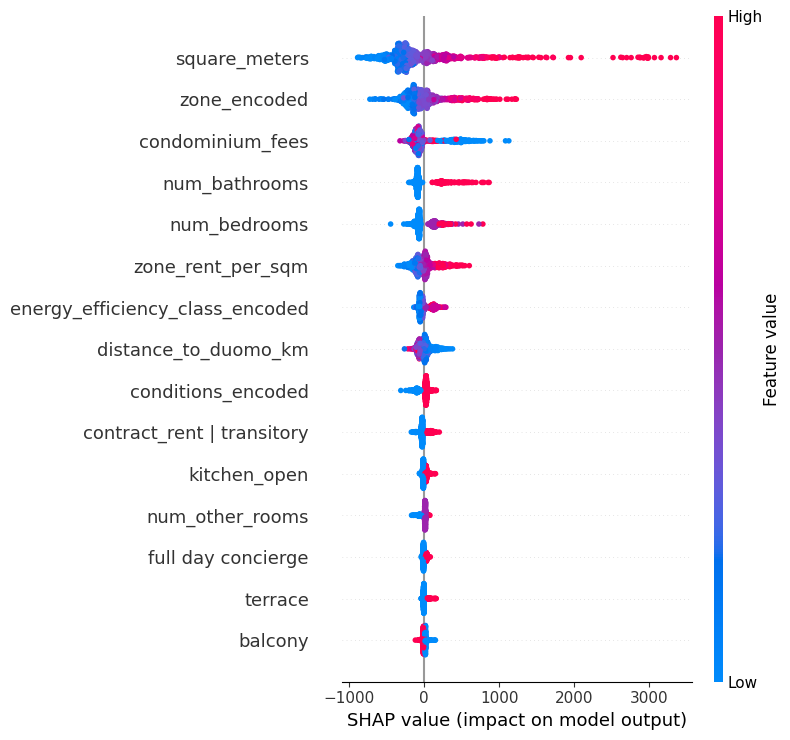

In [324]:
import shap

# 1. Load SHAP explainer for XGBoost model
explainer = shap.TreeExplainer(model)

# 2. Apply to validation data (or a sample of full data)
shap_values = explainer.shap_values(X_val)

# 3. Summary plot: shows global importance + impact
shap.summary_plot(shap_values, X_val, max_display=15)

# Improvement with square root of price and Interactions

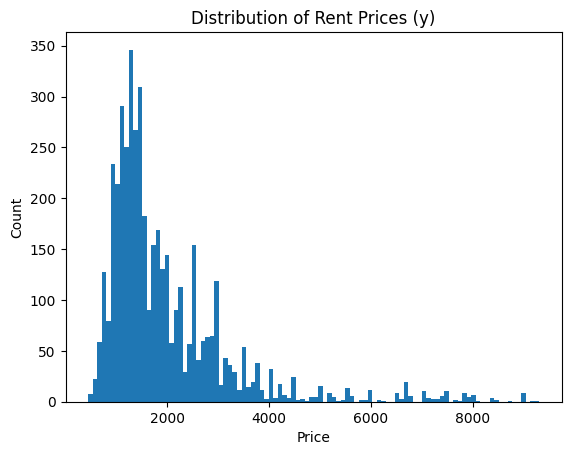

In [325]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(train['y'], bins=100)
plt.title("Distribution of Rent Prices (y)")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()


[0]	train-rmse:12.10223	eval-rmse:11.79152
[100]	train-rmse:3.90271	eval-rmse:5.03288
[200]	train-rmse:3.29418	eval-rmse:4.85572
[300]	train-rmse:2.96275	eval-rmse:4.80865
[400]	train-rmse:2.67121	eval-rmse:4.79508
[500]	train-rmse:2.42273	eval-rmse:4.78935
[600]	train-rmse:2.19532	eval-rmse:4.78501
[619]	train-rmse:2.15696	eval-rmse:4.78331
✅ Final Validation MAE (with sqrt(y)): 302.6831


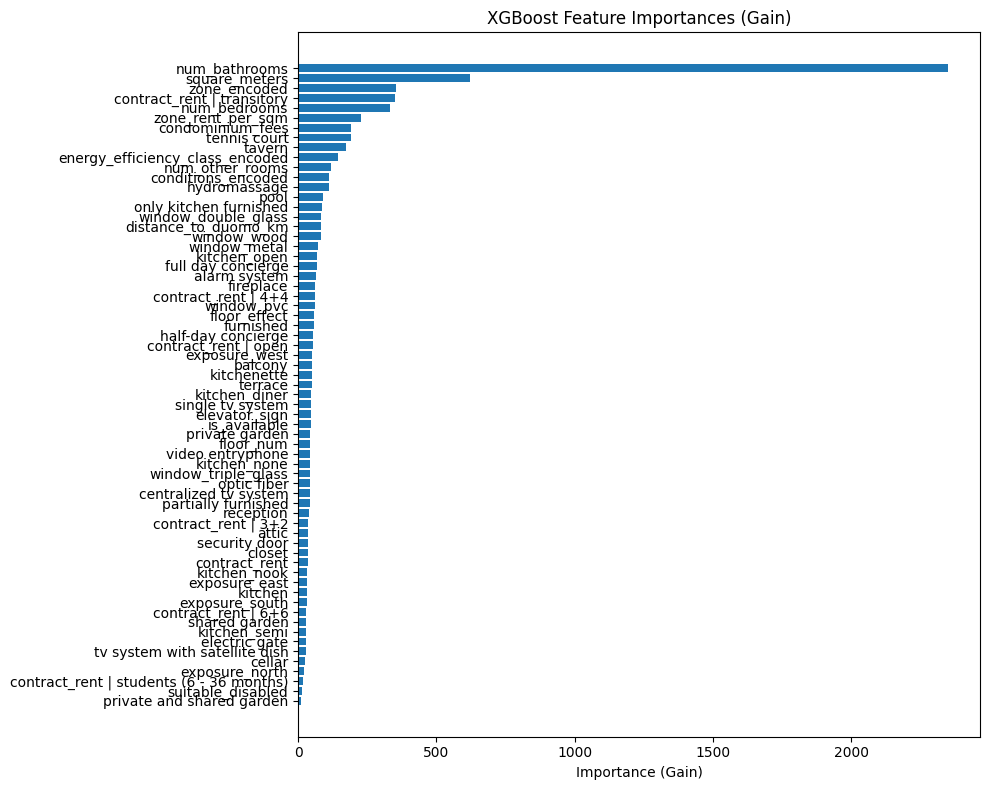

In [326]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Drop irrelevant columns ===
excluded_columns = [
    'y', 'contract_type', 'availability_encoded','availability', 'availability_date',
    'description', 'other_features', 'energy_efficiency_class',
    'energy_class_num', 'total_rooms', 'elevator', 'floor',
    'conditions', 'zone', 'zone_grouped','y_predicted'
]


X = train.drop(columns=excluded_columns, errors='ignore')
X_test = test.drop(columns=excluded_columns, errors='ignore')

# Align columns between train and test
missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X.columns]

# === Step 2: Define target with square root transformation ===
y = np.sqrt(train['y'])  # Transform the target

# === Step 3: Train-validation split ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# === Step 4: Wrap in DMatrix ===
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X.columns.tolist())
dval = xgb.DMatrix(X_val, label=y_val, feature_names=X.columns.tolist())
dtest = xgb.DMatrix(X_test, feature_names=X.columns.tolist())

# === Step 5: Set XGBoost parameters ===
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'seed': 42,
    'verbosity': 1
}
# === Step 6: Train with early stopping ===
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=100
)

# === Step 7: Predict and inverse transform ===
y_pred_val_sqrt = model.predict(dval)
y_pred_val = y_pred_val_sqrt ** 2  # Inverse transform

# MAE on original scale
mae = mean_absolute_error((y_val ** 2), y_pred_val)
print(f"✅ Final Validation MAE (with sqrt(y)): {mae:.4f}")

# === Step 8: Predict test and store ===
y_pred_test = model.predict(dtest) ** 2  # Inverse transform
test['y_predicted'] = y_pred_test

# === Step 9: Feature importance ===
importance_dict = model.get_score(importance_type='gain')
if importance_dict:
    importance_df = pd.DataFrame({
        'feature': list(importance_dict.keys()),
        'importance': list(importance_dict.values())
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['feature'].iloc[::-1], importance_df['importance'].iloc[::-1])
    plt.title("XGBoost Feature Importances (Gain)")
    plt.xlabel("Importance (Gain)")
    plt.tight_layout()
    plt.show()
else:
    print("No feature importance data available.")

# === Step 10: Save predictions ===
test['y_predicted'].to_csv(
    'submission2_sqrt_y.txt',
    index=False,
    header=False
)


In [327]:
# === Interaction Features Based on Top XGBoost Features ===
def add_interaction_features(df):
    # 1. Core size interactions
    df['bathrooms_x_sqm'] = df['num_bathrooms'] * df['square_meters']
    df['bathrooms_x_bedrooms'] = df['num_bathrooms'] * df['num_bedrooms']

    # 2. Location + size
    df['zone_x_sqm'] = df['zone_encoded'] * df['square_meters']
    df['zone_x_bathrooms'] = df['zone_encoded'] * df['num_bathrooms']


    return df


In [328]:
train = add_interaction_features(train)
test = add_interaction_features(test)


In [329]:
train.columns

Index(['y', 'square_meters', 'contract_type', 'availability', 'description',
       'other_features', 'conditions', 'floor', 'elevator',
       'energy_efficiency_class', 'condominium_fees', 'zone',
       'availability_date', 'is_available', 'availability_encoded',
       'energy_class_num', 'energy_efficiency_class_encoded',
       'conditions_encoded', 'floor_num', 'elevator_sign', 'floor_effect',
       'total_rooms', 'num_bedrooms', 'num_other_rooms', 'num_bathrooms',
       'kitchen_open', 'kitchen_diner', 'kitchen_nook', 'kitchen_semi',
       'kitchenette', 'kitchen_none', 'suitable_disabled', 'furnished',
       'security door', 'centralized tv system', 'optic fiber',
       'window_double_glass', 'balcony', 'full day concierge',
       'video entryphone', 'window_pvc', 'closet', 'electric gate',
       'shared garden', 'window_wood', 'window_metal', 'half-day concierge',
       'cellar', 'terrace', 'partially furnished', 'alarm system', 'kitchen',
       'only kitchen furnish

[0]	train-rmse:12.07761	eval-rmse:11.76250
[100]	train-rmse:3.90007	eval-rmse:5.02137
[200]	train-rmse:3.24032	eval-rmse:4.86202
[300]	train-rmse:2.87917	eval-rmse:4.81165
[400]	train-rmse:2.57202	eval-rmse:4.79554
[494]	train-rmse:2.32395	eval-rmse:4.78571
✅ Final Validation MAE (with sqrt(y)): 303.8459


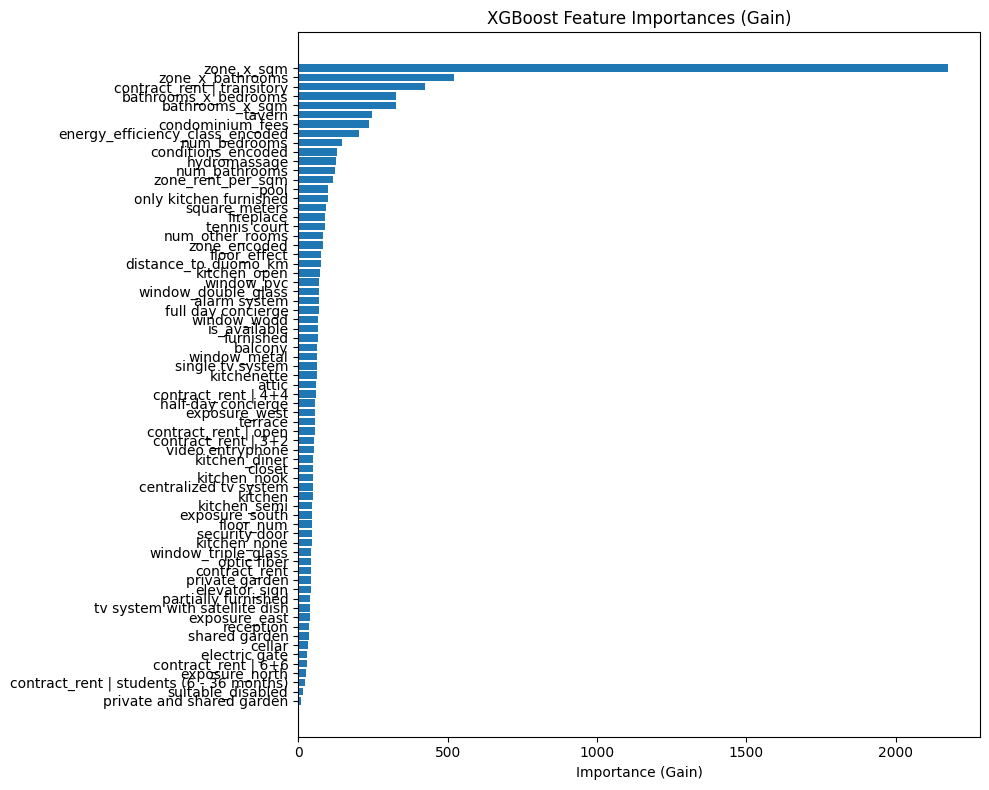

In [338]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Drop irrelevant columns ===
excluded_columns = [
    'y', 'contract_type', 'availability_encoded','availability', 'availability_date',
    'description', 'other_features', 'energy_efficiency_class',
    'energy_class_num', 'total_rooms', 'elevator', 'floor',
    'conditions', 'zone', 'zone_grouped','y_predicted'
]

X = train.drop(columns=excluded_columns, errors='ignore')
X_test = test.drop(columns=excluded_columns, errors='ignore')

# Align columns between train and test
missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X.columns]

# === Step 2: Define target with square root transformation ===
y = np.sqrt(train['y'])  # Transform the target

# === Step 3: Train-validation split ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# === Step 4: Wrap in DMatrix ===
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X.columns.tolist())
dval = xgb.DMatrix(X_val, label=y_val, feature_names=X.columns.tolist())
dtest = xgb.DMatrix(X_test, feature_names=X.columns.tolist())

# === Step 5: Set XGBoost parameters ===
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'seed': 42,
    'verbosity': 1
}
# === Step 6: Train with early stopping ===
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=100
)

# === Step 7: Predict and inverse transform ===
y_pred_val_sqrt = model.predict(dval)
y_pred_val = y_pred_val_sqrt ** 2  # Inverse transform

# MAE on original scale
mae = mean_absolute_error((y_val ** 2), y_pred_val)
print(f"✅ Final Validation MAE (with sqrt(y)): {mae:.4f}")

# === Step 8: Predict test and store ===
y_pred_test = model.predict(dtest) ** 2  # Inverse transform
test['y_predicted'] = y_pred_test

# === Step 9: Feature importance ===
importance_dict = model.get_score(importance_type='gain')
if importance_dict:
    importance_df = pd.DataFrame({
        'feature': list(importance_dict.keys()),
        'importance': list(importance_dict.values())
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['feature'].iloc[::-1], importance_df['importance'].iloc[::-1])
    plt.title("XGBoost Feature Importances (Gain)")
    plt.xlabel("Importance (Gain)")
    plt.tight_layout()
    plt.show()
else:
    print("No feature importance data available.")

# === Step 10: Save predictions ===
test['y_predicted'].to_csv(
    'submission2_sqrt_y.txt',
    index=False,
    header=False
)


# FINAL MODEL

[0]	train-rmse:12.07658	eval-rmse:11.76600
[100]	train-rmse:3.92869	eval-rmse:5.04369
[200]	train-rmse:3.29200	eval-rmse:4.90613
[300]	train-rmse:2.92372	eval-rmse:4.85312
[400]	train-rmse:2.62215	eval-rmse:4.83155
[500]	train-rmse:2.35813	eval-rmse:4.82630
[600]	train-rmse:2.12005	eval-rmse:4.82233
[621]	train-rmse:2.07477	eval-rmse:4.82254
✅ Final Validation MAE (with sqrt(y)): 305.5362


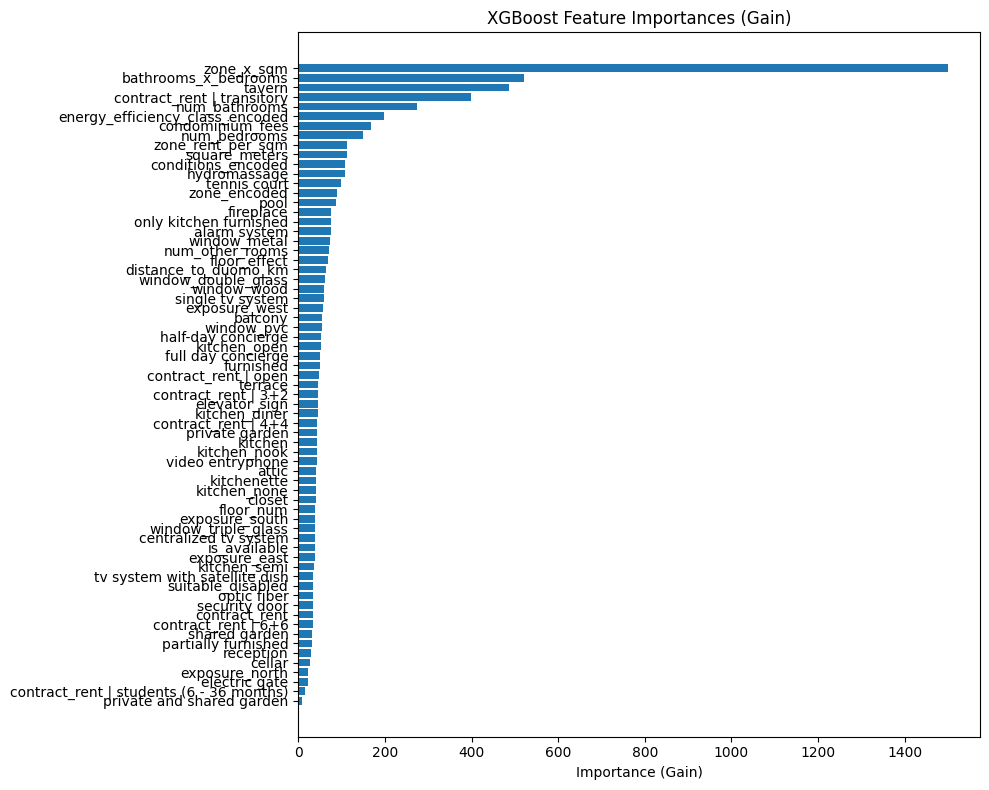

In [339]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Drop irrelevant columns ===
excluded_columns = [
    'y', 'contract_type', 'availability_encoded','availability', 'availability_date',
    'description', 'other_features', 'energy_efficiency_class',
    'energy_class_num', 'total_rooms', 'elevator', 'floor',
    'conditions', 'zone', 'zone_grouped','y_predicted','bathrooms_x_sqm',
     'zone_x_bathrooms'
]

X = train.drop(columns=excluded_columns, errors='ignore')
X_test = test.drop(columns=excluded_columns, errors='ignore')

# Align columns between train and test
missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X.columns]

# === Step 2: Define target with square root transformation ===
y = np.sqrt(train['y'])  # Transform the target

# === Step 3: Train-validation split ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# === Step 4: Wrap in DMatrix ===
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X.columns.tolist())
dval = xgb.DMatrix(X_val, label=y_val, feature_names=X.columns.tolist())
dtest = xgb.DMatrix(X_test, feature_names=X.columns.tolist())

# === Step 5: Set XGBoost parameters ===
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'seed': 42,
    'verbosity': 1
}
# === Step 6: Train with early stopping ===
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=100
)

# === Step 7: Predict and inverse transform ===
y_pred_val_sqrt = model.predict(dval)
y_pred_val = y_pred_val_sqrt ** 2  # Inverse transform

# MAE on original scale
mae = mean_absolute_error((y_val ** 2), y_pred_val)
print(f"✅ Final Validation MAE (with sqrt(y)): {mae:.4f}")

# === Step 8: Predict test and store ===
y_pred_test = model.predict(dtest) ** 2  # Inverse transform
test['y_predicted'] = y_pred_test

# === Step 9: Feature importance ===
importance_dict = model.get_score(importance_type='gain')
if importance_dict:
    importance_df = pd.DataFrame({
        'feature': list(importance_dict.keys()),
        'importance': list(importance_dict.values())
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['feature'].iloc[::-1], importance_df['importance'].iloc[::-1])
    plt.title("XGBoost Feature Importances (Gain)")
    plt.xlabel("Importance (Gain)")
    plt.tight_layout()
    plt.show()
else:
    print("No feature importance data available.")

# === Step 10: Save predictions ===
test['y_predicted'].to_csv(
    'submission2_sqrt_y.txt',
    index=False,
    header=False
)


[0]	train-rmse:12.07658	eval-rmse:11.76600
[100]	train-rmse:3.92869	eval-rmse:5.04369
[200]	train-rmse:3.29200	eval-rmse:4.90613
[300]	train-rmse:2.92372	eval-rmse:4.85312
[400]	train-rmse:2.62215	eval-rmse:4.83155
[500]	train-rmse:2.35813	eval-rmse:4.82630
[600]	train-rmse:2.12005	eval-rmse:4.82233
[621]	train-rmse:2.07477	eval-rmse:4.82254
🧪 MAE (rounded to €50):  303.94
🧪 MAE (rounded to €100): 304.30


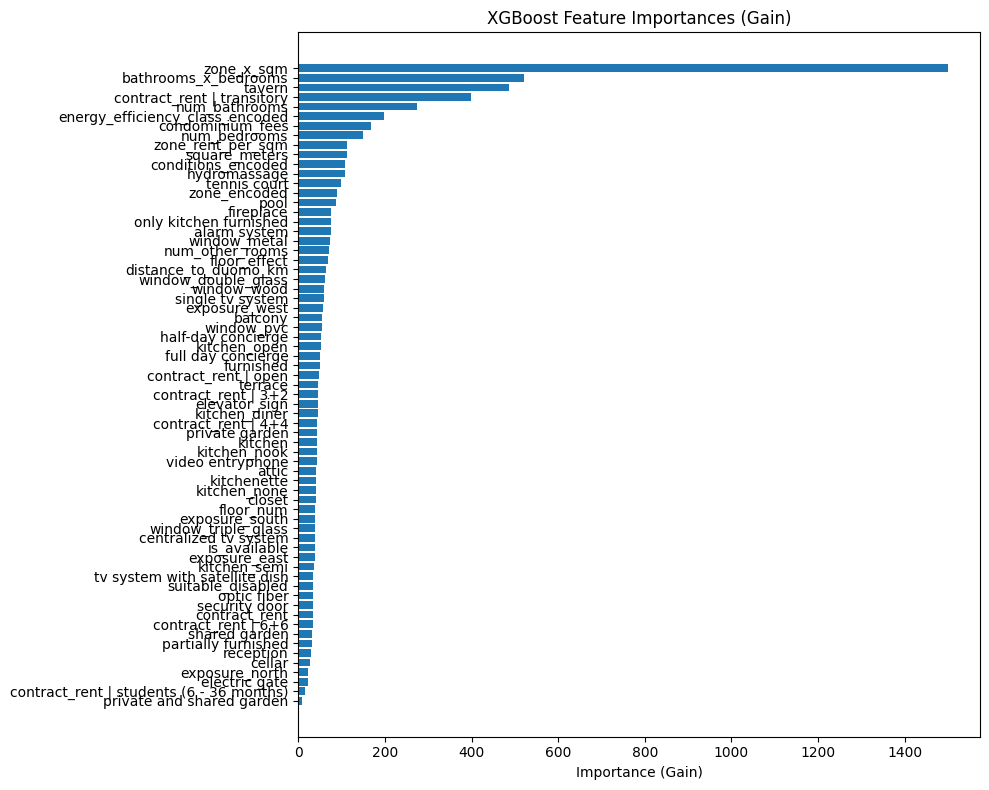

In [344]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Drop irrelevant columns ===
excluded_columns = [
    'y', 'contract_type', 'availability_encoded', 'availability', 'availability_date',
    'description', 'other_features', 'energy_efficiency_class',
    'energy_class_num', 'total_rooms', 'elevator', 'floor',
    'conditions', 'zone', 'zone_grouped', 'y_predicted',
    'bathrooms_x_sqm', 'zone_x_bathrooms'
]

X = train.drop(columns=excluded_columns, errors='ignore')
X_test = test.drop(columns=excluded_columns, errors='ignore')

# Align test columns with train
missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X.columns]

# === Step 2: Define target with square root transformation ===
y = np.sqrt(train['y'])

# === Step 3: Train-validation split ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# === Step 4: Wrap in DMatrix ===
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X.columns.tolist())
dval = xgb.DMatrix(X_val, label=y_val, feature_names=X.columns.tolist())
dtest = xgb.DMatrix(X_test, feature_names=X.columns.tolist())

# === Step 5: Set XGBoost parameters ===
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'seed': 42,
    'verbosity': 1
}

# === Step 6: Train with early stopping ===
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=100
)

# === Step 7: Predict and inverse transform ===
y_pred_val = model.predict(dval) ** 2
y_pred_test = model.predict(dtest) ** 2

# === Step 8: Round Predictions ===
y_pred_val_50 = (y_pred_val // 50).round() * 50
y_pred_val_100 = (y_pred_val // 100).round() * 100

# === Step 9: Evaluate MAE on validation set ===
mae_50 = mean_absolute_error((y_val ** 2), y_pred_val_50)
mae_100 = mean_absolute_error((y_val ** 2), y_pred_val_100)
print(f"🧪 MAE (rounded to €50):  {mae_50:.2f}")
print(f"🧪 MAE (rounded to €100): {mae_100:.2f}")

# === Step 10: Round test predictions ===
y_pred_test_50 = (y_pred_test // 50).round() * 50
y_pred_test_100 = (y_pred_test // 100).round() * 100

# === Step 11: Save predictions ===
test['y_predicted_50'] = y_pred_test_50
test['y_predicted_100'] = y_pred_test_100

test['y_predicted_50'].to_csv('submission_rounded_50.txt', index=False, header=False)
test['y_predicted_100'].to_csv('submission_rounded_100.txt', index=False, header=False)

# === Step 12: Feature importance plot ===
importance_dict = model.get_score(importance_type='gain')
if importance_dict:
    importance_df = pd.DataFrame({
        'feature': list(importance_dict.keys()),
        'importance': list(importance_dict.values())
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['feature'].iloc[::-1], importance_df['importance'].iloc[::-1])
    plt.title("XGBoost Feature Importances (Gain)")
    plt.xlabel("Importance (Gain)")
    plt.tight_layout()
    plt.show()
else:
    print("No feature importance data available.")
